# Probabilistic Topic Models

** Steyvers & Griffiths (2004) **

In [3]:
from IPython.display import display, Image

### A. Model in a Nutshell

##### Model

**NB: ** SG04 annotate *topic* with $z$ and $t$ interchangeably. We are sticking to $t$.

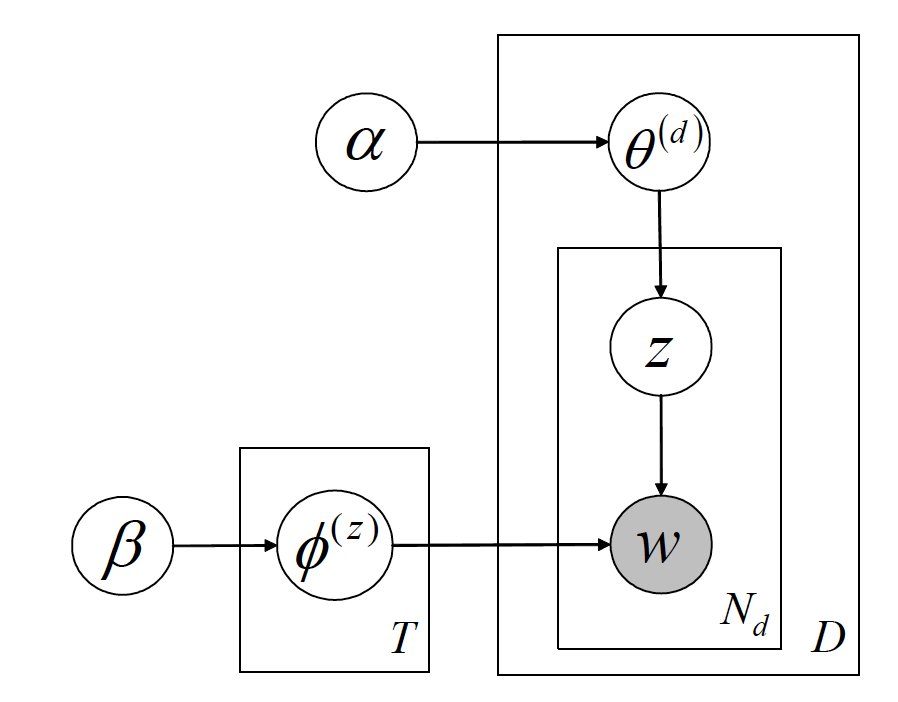

In [6]:
display(Image(filename='/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/LDA/FIGS/SG04_model.png',width='30%'))

##### Math

$\begin{align} P(w_i,t_j) &= P(w_i,t_j|\mathbf{w}_{-i},d_i,\cdot) \\ &\propto P(w_i|z_j)\cdot P(z_j|d_i) \\ &= \phi^{t_j}\cdot\theta^{d_i} \\ &\propto \frac{C_{w_i,t_j}^{WT} + \beta}{\sum_{w=1}^WC_{w_i,t_j}^{WT} + W\beta} \cdot \frac{C_{d_i,t_j}^{DT} + \alpha}{\sum_{t=1}^TC_{d_i,t_j}^{DT} + T\alpha} \end{align}$

* **Interpretation**: 

    * The probability of a word $w_i$ being assigned a topic $t$ (i.e. $P(w_i,t_j)$) is proportional to the product of the probability of having a word $w_i$ given $t_j$ (i.e. $P(w_i|z_j)$) and the probability of a topic $t_j$ being assigned to the word in a particular document $d_i$ (i.e. $P(z_j|d_i)$).
        * Note: $d_i$ does NOT mean *the $i$th document*, it instead means the document where $w_i$ is instantiated, since we are iterating over all words. Therefore $d_i$ can be read as *the current document*.
        
    * $\cdot$: various observed information (e.g. the current assigned topic distributions).
    
    * $\phi^{t_j}$: The multinomial distribution over all words for topic $t_j$.
    
    * $\theta^{d_i}$: The multinomial distribution over topics for document $d_i$.
    
    * $\mathbf{C}^{WT}$, $\mathbf{C}^{DT}$: The matrix of counts (dim: $W\times T$ and $D\times T$).
    
    * $C_{w_i,t_j}^{WT}$: The number of times a word $w_i$ is assigned to the topic $t_j$, *not including the current instance of $w_i$*.      
    
    * $C_{d_i,t_j}^{DT}$: The number of ties topic $t_j$ is assigned to some word token in document $d_i$, *again not including the current instance of $w_i$*.

### B. Toy Example

**Setup:**
* 5-word vocabulary: *river*, *stream*, *bank*, *money* and *loan*.
* 15 documents of three types (each type is represented by 5 documents): *Mixed*, *Single-Financial*, *Single-Scenery*.
    * Single-Financial: only contains words from the vocabulary {*bank*,*money*,*loan*} with uniform distribution (i.e. $\frac{1}{3}$ for each word to appear).
    * Single-Scenery: only contains words from the vocabulary {*river*,*stream*} with uniform distribution.
    * Mixed: contains words from the entire vocabulary with uniform distribution.
* Each document has 20 words.

In [31]:
import random
import numpy as np
from collections import Counter
import math
from operator import add, mul

In [448]:
def generate_documents():
    
    financial_vocab = ['bank','money','loan']
    scenery_vocab = ['river','stream']
    vocab = financial_vocab + scenery_vocab
    
    topic = lambda: 1 if random.uniform(0,1)>.5 else 0 
    
    documents = []
    
    documents += [[(random.choice(financial_vocab),topic()) for _ in xrange(20)] for _ in xrange(5)]
    documents += [[(random.choice(scenery_vocab),topic()) for _ in xrange(20)] for _ in xrange(5)]
    documents += [[(random.choice(vocab),topic()) for _ in xrange(20)] for _ in xrange(5)]
    
    return documents

In [449]:
documents = generate_documents() # a list of documents which are in the format [(word,topic),...].

In [450]:
import matplotlib.pyplot as plt
%matplotlib inline

In [451]:
def summarize_documents(documents):
    fc, ft = lambda d: [w for w,t in d], lambda d: [t for w,t in d]
    get_counts = lambda ds,f: Counter(reduce(add,map(f,ds)))
    c_financial, c_scenery, c_mixed = get_counts(documents[:5],fc), \
                                      get_counts(documents[5:10],fc), get_counts(documents[10:],fc)
    t_financial, t_scenery, t_mixed = get_counts(documents[:5],ft), \
                                      get_counts(documents[5:10],ft), get_counts(documents[10:],ft)
    CT = [c_financial,c_scenery,c_mixed,t_financial,t_scenery,t_mixed]
    print 'WORD & TOPIC COUNTS'
    plt.subplots(figsize=(12,4))
    for i in xrange(6):
        plt.subplot(230+i+1)
        color = 'blue' if i<3 else 'grey'
        plt.bar(np.arange(len(CT[i])),CT[i].values(),width=.7,align='center',color=color)
        plt.ylim(0,100)
        plt.xticks(np.arange(len(CT[i])) + .7*.05, CT[i].keys())  
    plt.show()

WORD & TOPIC COUNTS


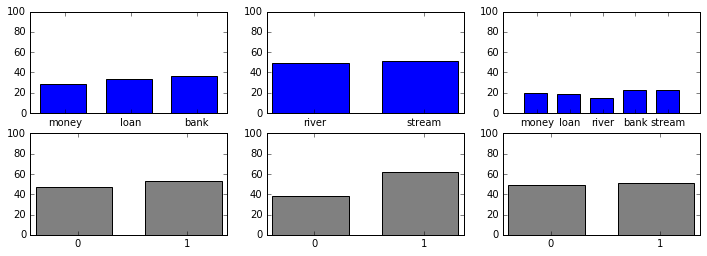

In [452]:
summarize_documents(documents)

In [453]:
print documents[0]
print len(documents)

[('loan', 1), ('bank', 1), ('loan', 0), ('loan', 1), ('money', 0), ('money', 1), ('money', 1), ('money', 1), ('bank', 1), ('money', 1), ('loan', 1), ('bank', 0), ('loan', 0), ('money', 0), ('loan', 0), ('money', 1), ('money', 0), ('money', 1), ('bank', 1), ('bank', 0)]
15


In [454]:
from __future__ import division

In [455]:
alpha, beta = 50/2, .001 # cf. SG04:5.

In [456]:
vocab = list(set(reduce(add,map(lambda d: [w for w,t in d], documents))))
w2i = {w:i for i,w in enumerate(vocab)}
topics = [0,1]
W = len(vocab)
D, T = len(documents), len(topics)

In [457]:
def get_counts(documents):
    C_WT, C_DT = np.zeros((W,T)), np.zeros((D,T))
    wt_counts = reduce(add,[Counter(d) for d in documents])
    for (w,t),count in wt_counts.iteritems():
        C_WT[w2i[w]][t] = count
    for i,d in enumerate(documents):
        dt_counts = Counter([t for w,t in d]) # format: Counter({0: count1, 1: count2}).
        for j in xrange(T):
            C_DT[i][j] = dt_counts[j]
    return C_WT, C_DT    

In [458]:
C_WT, C_DT = get_counts(documents)

In [459]:
print pd.DataFrame(C_WT,index=vocab)
print pd.DataFrame(C_DT)

           0     1
money   23.0  26.0
loan    23.0  30.0
river   24.0  40.0
stream  34.0  40.0
bank    30.0  30.0
       0     1
0    8.0  12.0
1   10.0  10.0
2    9.0  11.0
3   12.0   8.0
4    8.0  12.0
5    8.0  12.0
6    7.0  13.0
7    6.0  14.0
8    5.0  15.0
9   12.0   8.0
10  12.0   8.0
11  10.0  10.0
12   8.0  12.0
13   9.0  11.0
14  10.0  10.0


In [437]:
def sample_topic(i,j,d): # i,j,d: indices of word, topic and document
    # compute normalizing constant
    Z = sum( ((C_WT[i][k]+beta) / (sum(C_WT[w][k] for w in xrange(W))+W*beta)) * \
             ((C_DT[d][k]+alpha) / (sum(C_DT[d][t] for t in xrange(T))+T*alpha)) 
            for k in xrange(T)) 
        # w: temp var for word, over all words.
        # t,k: temp vars for topic, over all topics.
    P = [( ((C_WT[i][j]+beta) / (sum(C_WT[w][j] for w in xrange(W))+W*beta)) * \
           ((C_DT[d][j]+alpha) / (sum(C_DT[d][t] for t in xrange(T))+T*alpha)) ) / Z
          for j in xrange(T)]
    return np.random.choice(np.array(topics),p=np.array(P))

In [460]:
# GIBBS
C_WT, C_DT = get_counts(documents)
for _ in xrange(64):
    for d,doc in enumerate(documents):
        for idx,(i,j) in enumerate(doc): # doc: [(w_i,t_j), ...]
            C_WT[w2i[i]][j] -= 1
            C_DT[d][j] -= 1
            new_topic = sample_topic(w2i[i],j,d) # w2i: look up word's index.
            doc[idx] = (i,new_topic)
            C_WT[w2i[i]][new_topic] += 1
            C_DT[d][new_topic] += 1

In [461]:
print pd.DataFrame(C_WT,index=vocab)
print pd.DataFrame(C_DT) 

           0     1
money    0.0  49.0
loan     0.0  53.0
river   64.0   0.0
stream  74.0   0.0
bank     0.0  60.0
       0     1
0    0.0  20.0
1    0.0  20.0
2    0.0  20.0
3    0.0  20.0
4    0.0  20.0
5   20.0   0.0
6   20.0   0.0
7   20.0   0.0
8   20.0   0.0
9   20.0   0.0
10   8.0  12.0
11   7.0  13.0
12   7.0  13.0
13   6.0  14.0
14  10.0  10.0


WORD & TOPIC COUNTS


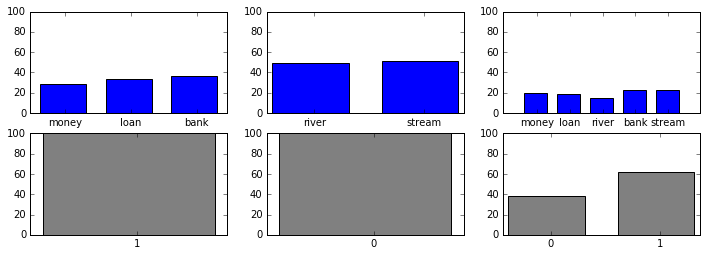

In [462]:
summarize_documents(documents)